### Data is sourced from:

https://nces.ed.gov/programs/digest/index.asp

In [1]:
#Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce
import scipy.stats as stats
import seaborn as sns
from matplotlib.patches import Rectangle

%matplotlib inline
plt.style.use('seaborn-colorblind')

### Reading in Relevant Dataset

In [2]:

#2005-2015: Reading in mulitple excels because they don't contain all the years
old_2006_2009 = pd.read_excel('data/2006_2009.xls', skiprows=range(3)) #<-- 2005,2007,2008,2009
load_2006 = pd.read_excel('data/2006.xls', skiprows = range(6)) #<-- 2006
sat_1995_2015 = pd.read_excel('data/SAT_1995_2015.xls', skiprows=range(3)) #<-- 2010, 2013, 2014


load_2011_2012 = pd.read_excel('data/2010-2012.xls', skiprows=range(5)) #<-- 2011, 2012
load_2015 = pd.read_excel('data/2015.xls', skiprows=range(5)) #<-- 2015


sat_1987_1998 = pd.read_excel('data/SAT_1987_1998.xls', skiprows=range(11))
sat_2017_2018 = pd.read_excel('data/SAT_2017_2018.xls', skiprows=range(5))
#Remove unwanted rows and columns
sat_2017 = sat_2017_2018.iloc[:-3, :8] 
sat_2018 = sat_2017_2018.iloc[:-3, 8:] 


#Relevant to ethnicity
race = pd.read_excel('data/race_score.xls')
race = race.iloc[3:41, :17]
race.drop(race.columns[[1,2,3,4,5,6]], axis=1, inplace=True)
race.columns = ['Ethnicity', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014']

### Old SAT format: 2400 score. Lasted from 2005-2015

In [3]:
#Helper functions


#Get the clean list of states from the DF.
def clean_states(df:pd.DataFrame) -> list:
    '''States column contains unwanted text('.').
    Strips unwanted text to merge dataframes more seemlessly'''
    
    states_list = []
    for i in df.iloc[:, 0]:
        states_list.append(i.split('.')[0])
        
    return states_list



#Cleaning up data and splitting the DF
def clean_multi_dataset(df, renamed_col = ['State', 'Reading', 'Math', 'Writing']):
    for i in range(1, len(df.columns) - 1, 3):
        data_year = df.iloc[:,i:i+3]
        data_year.insert(0, 'States', clean_states(df))
        
        data_year.columns = renamed_col
        
        data_year['SAT Total Score'] = data_year.apply(lambda row: row.Reading + row.Math + row.Writing, axis=1)

        yield data_year
    
  
#For df that only contain 1 year needed:
def clean_dataset(df, start, end, renamed_col = ['State', 'Reading', 'Math', 'Writing']):
    data_year = df.iloc[:, start:end]

    data_year.insert(0, 'States', clean_states(df))
    data_year.columns = renamed_col
    data_year['SAT Total Score'] = data_year.apply(lambda row: row.Reading + row.Math + row.Writing, axis=1)

    return data_year

Clean table of NaN rows and columns and nonuseful data.

In [4]:
def remove_nan(df):
    return df[pd.notnull(df.iloc[:,1])]

In [5]:
load_2006.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,Unnamed: 16,17,Unnamed: 18
0,United States .....,505.0,501.0,505.0,508.0,506.0,514.0,508.0,520.0,503.0,518.0,497.0,502.0,515.0,494.0,48.0,NaN,48.0,NaN
1,Alabama .......................,554.0,540.0,565.0,558.0,559.0,554.0,567.0,559.0,565.0,561.0,565.0,563.0,556.0,554.0,9.0,NaN,9.0,NaN
2,Alaska ........................,518.0,501.0,521.0,513.0,514.0,510.0,523.0,519.0,517.0,517.0,493.0,519.0,517.0,491.0,51.0,NaN,48.0,NaN
3,Arizona ......................,531.0,523.0,525.0,521.0,523.0,525.0,526.0,530.0,521.0,528.0,507.0,519.0,525.0,502.0,32.0,NaN,32.0,NaN
4,Arkansas ......................,554.0,536.0,566.0,550.0,562.0,550.0,563.0,552.0,574.0,568.0,567.0,578.0,566.0,565.0,5.0,NaN,5.0,NaN


Cleaning data of NaN values. Ready for splitting and filtering

In [6]:
#For 2006
data_2006 = remove_nan(load_2006)

#For 2005, 2007, 2008, 2009
old_2006_2009 = remove_nan(old_2006_2009).drop(columns=[2,3,4,5,18,19])

#For 2010, 2013, 2014
sat_1995_2015 = remove_nan(sat_1995_2015).drop(columns=[2,3,4,5,6,7,8,18,19])

#For 2011, 2012
load_2011_2012 = remove_nan(load_2011_2012)

#For 2015
load_2015 = remove_nan(load_2015)

Apply functions to dataset to be separated into their respective years.

In [7]:
#Relevant tables for 2005-2010:
cleaned_2005_2009 = clean_multi_dataset(old_2006_2009) #<-- 2005, 2007, 2008, 2009

#Relevant tables for both:
cleaned_10_13_14 = clean_multi_dataset(sat_1995_2015) #<-- 2010, 2013, 2014

#Relevant for 2011-2015
cleaned_11_12 = clean_multi_dataset(load_2011_2012) #<-- 2011, 2012
#load_2015

In [8]:
# Data for 2005-2010:
sat_2005 = next(cleaned_2005_2009)
sat_2006 = clean_dataset(data_2006, 12, 15)
sat_2007 = next(cleaned_2005_2009)

sat_2008 = next(cleaned_2005_2009)
sat_2009 = next(cleaned_2005_2009)
sat_2010 = next(cleaned_10_13_14)

In [9]:
# #Data for 2011-2015:
sat_2011 = next(cleaned_11_12)
sat_2012 = next(cleaned_11_12)
sat_2013 = next(cleaned_10_13_14)

sat_2014 = next(cleaned_10_13_14)
sat_2015 = clean_dataset(load_2015, 14, 17)

In [10]:
sat_2005.head()

,State,Reading,Math,Writing,SAT Total Score
0,United States,503.0,518.0,497.0,1518.0
1,Alabama,565.0,561.0,565.0,1691.0
2,Alaska,517.0,517.0,493.0,1527.0
3,Arizona,521.0,528.0,507.0,1556.0
4,Arkansas,574.0,568.0,567.0,1709.0


How does race play into SAT scores? Cleaning up data.

In [11]:
#Throw away names
sat_reading = race.iloc[:12,:]
sat_math = race.iloc[14:25, :]
sat_writing = race.iloc[27:-1,:]

sat_writing = remove_nan(sat_writing)
sat_reading = remove_nan(sat_reading)
sat_math = remove_nan(sat_math)

#Similar to the clean states but return df
def clean_junk(df:pd.DataFrame) -> pd.DataFrame:
    '''column contains unwanted text('.').
    Strips unwanted text to merge dataframes more seemlessly'''
    
    list_ = []
    for i in df.iloc[:, 0]:
        list_.append(i.split('.')[0])
    df.iloc[:,0] = list_    
    return df
_1 = clean_junk(sat_math).reset_index()
_2 = clean_junk(sat_writing).reset_index()
_3 = clean_junk(sat_reading).reset_index()

#Not the most efficient way to do it??
df_add = _1.iloc[1:-1,2:].add(_2.iloc[1:-1,2:], fill_value=0)
df_eth = df_add.add(_3.iloc[1:-1,2:])
df_eth.insert(0, 'Ethnicity', _1.iloc[:,1])
lst_ = ['White', 'Black', 'Mexican American', 'Asian', 'American Indian']


#Drop similar ethnic groups if score is similar
df_eth.drop([4,5], axis=0, inplace=True)
df_eth['Ethnicity'] = lst_

df_eth

,Ethnicity,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
1,White,1582,1579,1583,1581,1580,1579,1578,1576,1576,1576
2,Black,1291,1287,1280,1276,1277,1272,1273,1278,1278,1277
3,Mexican American,1371,1371,1364,1362,1369,1362,1356,1355,1354,1343
6,Asian,1600,1605,1610,1623,1636,1640,1641,1645,1651,1654
7,American Indian,981,981,976,979,977,972,971,966,967,963


### 2005-2010 SAT Total Score for each State: 


In [12]:
#2005-2010 Average Total Score per state to be plotted

to_merge = [sat_2005[['State', 'SAT Total Score']], sat_2006[['State', 'SAT Total Score']], sat_2007[['State', 'SAT Total Score']], 
            sat_2008[['State', 'SAT Total Score']], sat_2009[['State', 'SAT Total Score']], sat_2010[['State', 'SAT Total Score']]]



Each year has a total score. Merging years and also adding a column for average over the years.

In [13]:
#Merge dataframes 2005-2010

df = reduce(lambda x, y: pd.merge(x,y, on='State', how='inner'), to_merge)
df.columns = ['States', '2005 SAT Scores', '2006 SAT Scores', '2007 SAT Scores', '2008 SAT Scores', '2009 SAT Scores', '2010 SAT Scores']

Sort by descending values

In [14]:
#Add average over the 6 years and sort by descending values
df['Average Over 6 Years'] = df.drop('States', axis=1).apply(lambda x: x.mean(), axis=1)
df.sort_values(['Average Over 6 Years'], axis=0, ascending=True, inplace=True)

In [15]:
df.head(10)

,States,2005 SAT Scores,2006 SAT Scores,2007 SAT Scores,2008 SAT Scores,2009 SAT Scores,2010 SAT Scores,Average Over 6 Years
37,South Carolina,1465.0,1459.0,1461.0,1452.0,1447.0,1436.0,1453.333333
10,Hawaii,1463.0,1463.0,1453.0,1450.0,1458.0,1448.0,1455.833333
9,Georgia,1477.0,1472.0,1466.0,1460.0,1453.0,1445.0,1462.166667
40,Texas,1484.0,1481.0,1473.0,1467.0,1462.0,1446.0,1468.833333
8,Florida,1473.0,1472.0,1474.0,1475.0,1473.0,1447.0,1469.000000
29,New York,1486.0,1478.0,1473.0,1465.0,1461.0,1460.0,1470.500000
35,Pennsylvania,1476.0,1474.0,1478.0,1477.0,1473.0,1473.0,1475.166667
25,Nevada,1487.0,1486.0,1482.0,1485.0,1470.0,1460.0,1478.333333
12,Indiana,1493.0,1487.0,1485.0,1483.0,1476.0,1469.0,1482.166667
36,Rhode Island,1487.0,1486.0,1486.0,1488.0,1477.0,1477.0,1483.500000


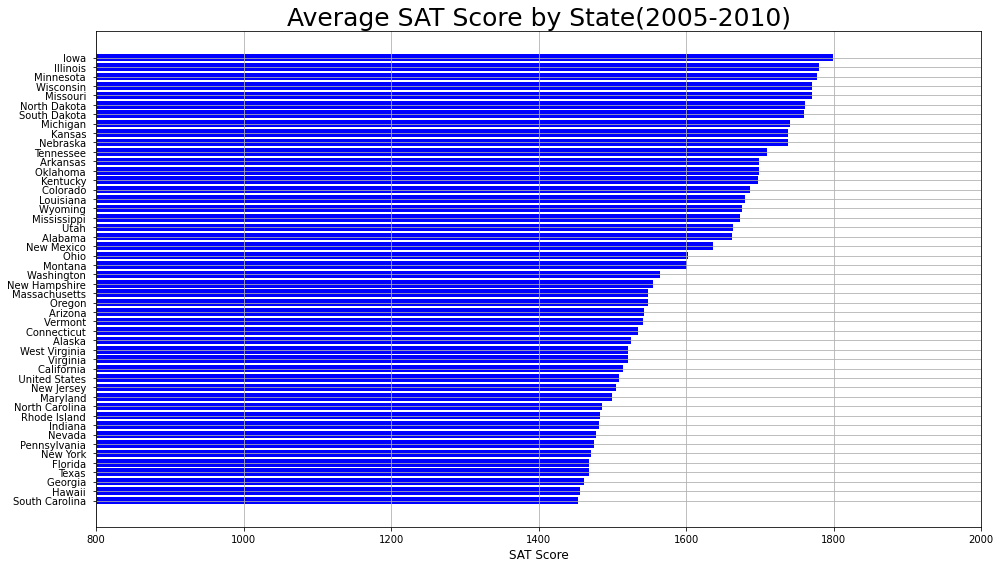

In [16]:
#Bar graph for first 6 years
x = df['States']

fig, ax = plt.subplots(figsize=(14,8))
ax.barh(x, df['Average Over 6 Years'], color='blue')

ax.grid(linestyle='-')
plt.tight_layout()
ax.set_xlim(800, 2000)
ax.set_title('Average SAT Score by State(2005-2010)', fontsize=25)
plt.xlabel('SAT Score', fontsize=12)
fig.tight_layout()

# plt.savefig('AverageSAT2005_2010.png')

### 2011-2015 SAT Total Score for each State: 

In [17]:
#Average total score 2011-2015 to be plotted
merge_ = [sat_2011[['State', 'SAT Total Score']], sat_2012[['State', 'SAT Total Score']], sat_2013[['State', 'SAT Total Score']], 
            sat_2014[['State', 'SAT Total Score']], sat_2015[['State', 'SAT Total Score']]]

Doing the same process as above for the rest of the years

In [18]:
#Merging dataframes together
df2 = reduce(lambda x, y: pd.merge(x,y, on='State', how='inner'), merge_)
df2.columns = ['States', '2011 SAT Scores', '2012 SAT Scores', '2013 SAT Scores', '2014 SAT Scores', '2015 SAT Scores']

In [19]:
#Add average over 5 years column
df2['Average Over 5 Years'] = df2.drop('States', axis=1).apply(lambda x: x.mean(), axis=1)
df2.sort_values(['Average Over 5 Years'], axis=0, ascending=True, inplace=True)
df2.head()

,States,2011 SAT Scores,2012 SAT Scores,2013 SAT Scores,2014 SAT Scores,2015 SAT Scores,Average Over 5 Years
38,Texas,1488.0,1496.0,1432.0,1410.0,1393.0,1443.8
35,South Carolina,1440.0,1473.0,1443.0,1442.0,1458.0,1451.2
6,Florida,1492.0,1492.0,1448.0,1434.0,1418.0,1456.8
7,Georgia,1452.0,1479.0,1445.0,1450.0,1459.0,1457.0
8,Hawaii,1481.0,1506.0,1460.0,1472.0,1478.0,1479.4


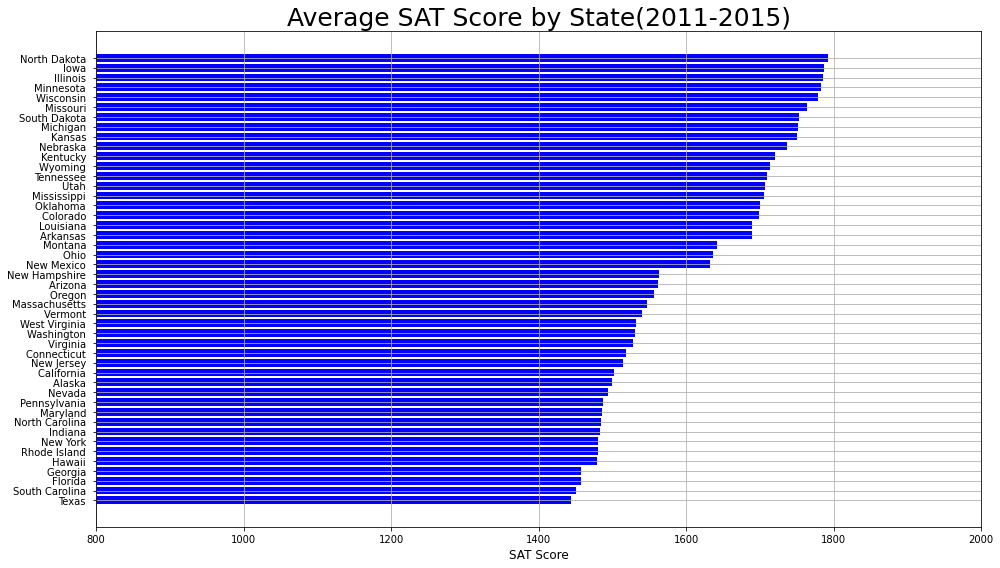

In [20]:
#Plotting
x = df2['States']

fig, ax = plt.subplots(figsize=(14,8))
ax.barh(x, df2['Average Over 5 Years'], color='blue')

ax.grid(linestyle='-')
ax.set_xlim(800, 2000)
ax.set_title('Average SAT Score by State(2011-2015)', fontsize=25)
plt.xlabel('SAT Score', fontsize=12)
fig.tight_layout()


plt.savefig('AverageSAT2011_2015.png')

In [21]:
#Curiousity: See which States held their top 10 status.
top_10_first_6_years = df[['States', 'Average Over 6 Years']].tail(10)
top_10_last_5_years = df2[['States', 'Average Over 5 Years']].tail(10)

In [22]:
#The States that were in the top 10 in 2005-2010 that held their top 10 spot in 2011-2015

reoccuring = top_10_first_6_years.merge(top_10_last_5_years, on='States', how='inner')
reoccuring.columns = ['States', 'Average Score(2005-2010)', 'Average Score(2011-2015)']
reoccuring



,States,Average Score(2005-2010),Average Score(2011-2015)
0,Nebraska,1738.000000,1736.4
1,Kansas,1738.833333,1749.8
2,Michigan,1740.833333,1752.2
3,South Dakota,1759.500000,1752.6
4,North Dakota,1760.666667,1791.8
5,Missouri,1770.166667,1764.2
6,Wisconsin,1770.333333,1779.0
7,Minnesota,1777.666667,1782.8
8,Illinois,1780.833333,1785.4
9,Iowa,1799.666667,1787.0


### Statistical Analysis & EDA

Put all values into an array to be thrown into a scatter plot. 

In [23]:
test = df.iloc[:,1:-1].values
test2 = df2.iloc[:, 1:-1].values

# sample1 = np.random.choice(test.flatten(), len(test))   Deprecated, save for possible use later
# sample2 = np.random.choice(test2.flatten(), len(test2))  Depracted, save for possible use later

#Scatter Plot
first_df = df.drop(['Average Over 6 Years'], axis=1)
df_plot = [first_df['2005 SAT Scores'], first_df['2006 SAT Scores'], first_df['2007 SAT Scores'],
             first_df['2008 SAT Scores'], first_df['2009 SAT Scores'], first_df['2010 SAT Scores']]

second_df = df2.drop(['Average Over 5 Years'], axis=1)
df2_plot = [second_df['2011 SAT Scores'], second_df['2012 SAT Scores'], second_df['2013 SAT Scores'],
       second_df['2014 SAT Scores'], second_df['2015 SAT Scores']]


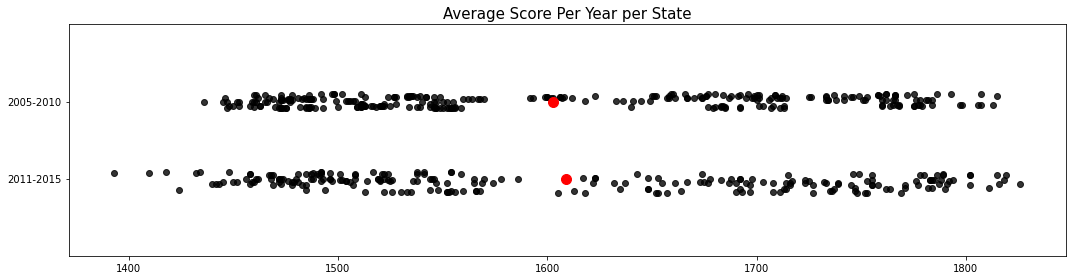

In [24]:

fig, ax = plt.subplots(figsize=(15,4))
jitter = np.random.uniform(-0.2, 0.1, size=second_df['2011 SAT Scores'].shape)
jitter1 = np.random.uniform(0.9, 1.1, size=first_df['2005 SAT Scores'].shape)


#2011-2015 Scatter plot
for i in df2_plot:
    ax.scatter(i, jitter, color='k', alpha=0.8)
#Mean for 2011-2015 in red
ax.scatter(test2.mean(), 0, color='red', s=100)


#2005-2010 Scatterplot
for i in df_plot:
    ax.scatter(i, jitter1, color='k', alpha=0.8)
    
#Mean for 2005-2010 in red
ax.scatter(test.mean(), 1, color='red', s=100)

#Make plot look better
ax.set_yticks([0,1])
ax.set_yticklabels(["2011-2015", '2005-2010'])
ax.set_ylim(-1,2)

ax.set_title('Average Score Per Year per State', fontsize=15)
fig.tight_layout()

# plt.savefig('Comparison.png')

Large spread with clusters at each end. Look through ethnicity as a factor

In [84]:
#Reminder:
df_eth

,Ethnicity,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
1,White,1582,1579,1583,1581,1580,1579,1578,1576,1576,1576
2,Black,1291,1287,1280,1276,1277,1272,1273,1278,1278,1277
3,Mexican American,1371,1371,1364,1362,1369,1362,1356,1355,1354,1343
6,Asian,1600,1605,1610,1623,1636,1640,1641,1645,1651,1654
7,American Indian,981,981,976,979,977,972,971,966,967,963


Give me a break plz. Dataframe is setup to make life as hard as possible. Transposing to make plotting easier

In [155]:
ethn_sat = df_eth.T.reset_index()
ethn_sat.columns = ['Year', 'White', 'Black', 'Mexican American', 'Asian', 'American Indian']
ethn_sat.drop([0], inplace=True)

ethn_sat.set_index(['Year'], inplace=True)
ethn_sat

,White,Black,Mexican American,Asian,American Indian
Year,,,,,
2005,1582,1291,1371,1600,981
2006,1579,1287,1371,1605,981
2007,1583,1280,1364,1610,976
2008,1581,1276,1362,1623,979
2009,1580,1277,1369,1636,977
2010,1579,1272,1362,1640,972
2011,1578,1273,1356,1641,971
2012,1576,1278,1355,1645,966
2013,1576,1278,1354,1651,967


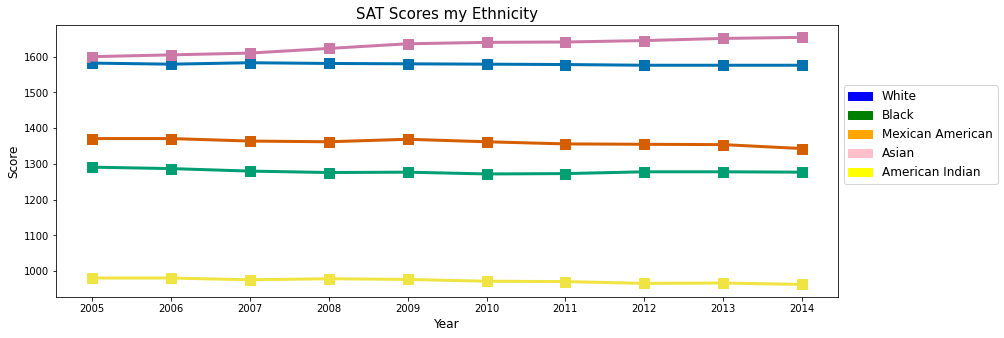

In [161]:
fig, ax = plt.subplots(figsize=(14,5))
handle = [Rectangle((0,0),1,1,color=c) for c in ['blue', 'green', 'orange', 'pink', 'yellow']]

for i in throw.columns:
    ax.plot(ethn_sat.index, ethn_sat[i], linewidth=3)
    ax.scatter(ethn_sat.index, ethn_sat[i], marker='s', s=100)

ax.set_title('SAT Scores my Ethnicity', size=15)
ax.set_xlabel('Year', size=12)
ax.set_ylabel('Score', size=12)
ax.legend(handle, ethn_sat.columns, prop={'size':12}, bbox_to_anchor=(1,0.8))

# plt.savefig('ethnicity_comparison.png')

Histogram by subject

In [25]:
#Merger function to plot by subject

def subject_merge(df_list):
    return reduce(lambda x, y: pd.merge(x,y, on='State', how='inner'), df_list)


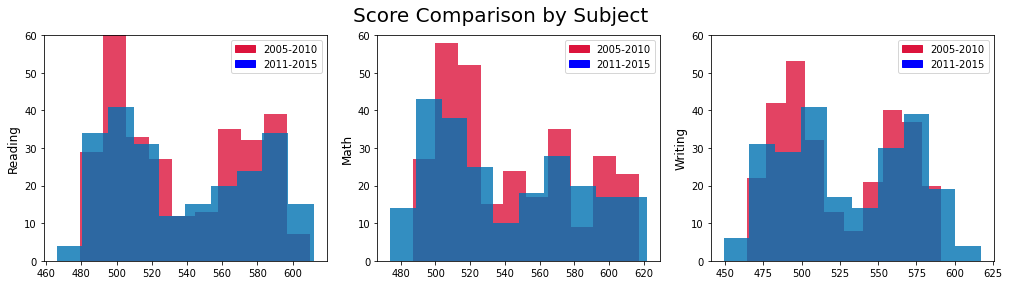

In [26]:
#To rename columns
subjects = ['','Reading', 'Math', 'Writing']

#Arguments for merger function
first_half = [sat_2005, sat_2006, sat_2007,
              sat_2008, sat_2009, sat_2010]

latter_half = [sat_2011, sat_2012, sat_2013, 
            sat_2014, sat_2015]


#Change variable name once morale has returned
please = subject_merge(first_half)
help_me = subject_merge(latter_half)

fig, axs = plt.subplots(1,3, figsize=(14,4))

#Plot 2005-2010 subjects
for i, ax in enumerate(axs,1):
    ax.hist(please.iloc[:,i::4].values.flatten(), color='crimson', bins=10, alpha=0.8)
    ax.set_ylabel(f'{subjects[i]}', fontsize=12)
    ax.set_ylim(0,60)

#Plot for 2011-2015
for i, ax in enumerate(axs, 1):
    ax.hist(help_me.iloc[:, i::4].values.flatten(), bins=10, alpha=0.8)
#     ax.set_ylabel(f'{subjects[i]}', fontsize=12)
#     ax.set_ylim(0,60)

#Setting up legend
handles = [Rectangle((0,0),1,1,color=c) for c in ['crimson', 'blue']]
labels = ['2005-2010', '2011-2015']
for ax in axs:
    ax.legend(handles, labels)

fig.suptitle('Score Comparison by Subject', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.88)

# plt.savefig('subject_comparison.png')

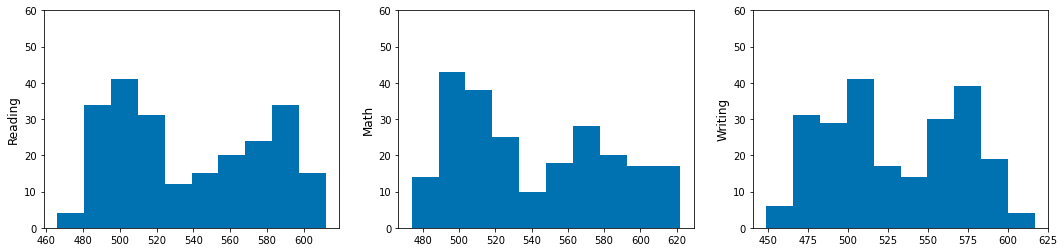

In [27]:
fig, axs = plt.subplots(1,3, figsize=(18,4))

for i, ax in enumerate(axs, 1):
    ax.hist(help_me.iloc[:, i::4].values.flatten(), bins=10)
    ax.set_ylabel(f'{subjects[i]}', fontsize=12)
    ax.set_ylim(0,60)
    
#Deprecated plot plotted on top of the other above

Pairwise comparison of subjects

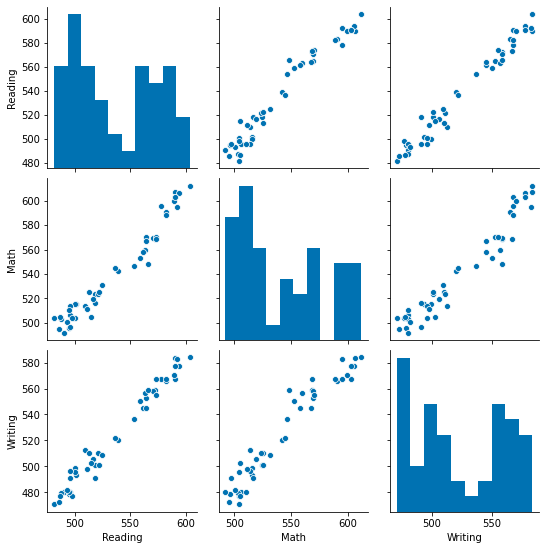

In [28]:
#Null: There is no difference in the average SAT scores of 2005-2010 and the average SAT scores of 2011-2015
for i in range(1,4):
    please[i] = please.iloc[:, i::4].mean(axis=1)
please.rename(columns = {1:'Reading', 2: 'Math', 3: 'Writing'}, inplace=True)

sns.pairplot(please[['Reading', 'Math', 'Writing']])

### 2017-2018 EDA

In [29]:
#Cleaning Functions for revised SAT test
def new_sat_cleaning(df, start, end, rename_col=['State', 'Total', 'Reading + Writing', 'Math']):
    data_year = df.iloc[:, start:end:2]
    
    data_year.insert(0, 'States', clean_states(df))
    data_year.columns = rename_col
    
    return data_year

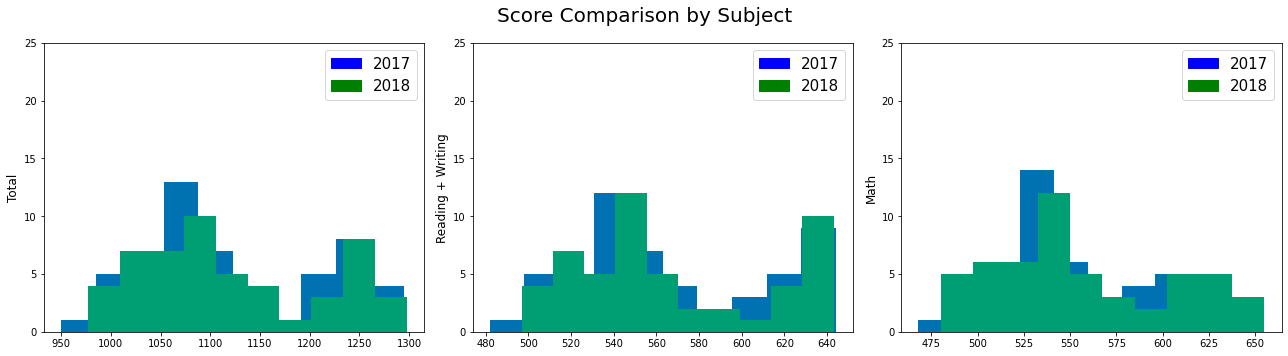

In [30]:
cleaned_ = sat_2017_2018[pd.notnull(sat_2017_2018.iloc[:,2])]

#Cleaning up 2017 and 2018 year to be plotted
clean_2017 = new_sat_cleaning(cleaned_, 1, 7)
clean_2018 = new_sat_cleaning(cleaned_, 8, 14)



fig, axs = plt.subplots(1,3, figsize=(18,5))
labels = ['', 'Total', 'Reading + Writing', 'Math']
for i, ax in enumerate(axs, 1):
    ax.hist(clean_2017.iloc[:, i].values, bins=10)
    ax.set_ylabel(labels[i], fontsize=12)
    ax.set_ylim(0,25)
    ax.hist(clean_2018.iloc[:, i].values, bins=10)
    
handles = [Rectangle((0,0),1,1,color=c) for c in ['blue', 'green']]
labels = ['2017', '2018']
for ax in axs:
    ax.legend(handles, labels, prop={'size':15})

fig.suptitle('Score Comparison by Subject', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
    

# plt.savefig('2017_2018_Comparison.png')

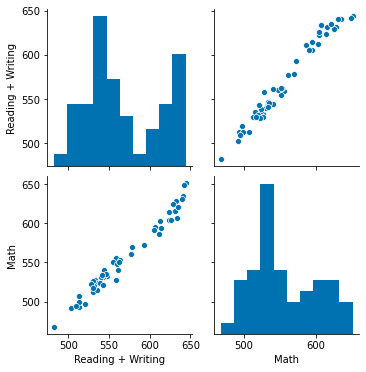

In [31]:
sns.pairplot(clean_2017[['Reading + Writing', 'Math']])

plt.savefig('pairwise_relationship_latest.png')

In [32]:
#We can infer that the null hypothesis is true based on the scatter plot above. For completion sake,
#Performed U test to confirm hypothesis test.

def count_winning_pairs(sample_1, sample_2):
    n_total_wins = 0
    for x in sample_1:
        n_wins = np.sum(x > sample_2) + 0.5*np.sum(x == sample_2)
        n_total_wins += n_wins
    return n_total_wins

In [33]:
#Score comparison where the 2005-2010 > 2011-2015
old_wins = count_winning_pairs(test.flatten(), test2.flatten())
#Score comparison where 2011-2015 > 2005-2010
new_wins = count_winning_pairs(test2.flatten(), test.flatten())


print(old_wins)
print(new_wins)

32160.5
34079.5


In [34]:
#U test to get the p-value
#Not expecting a large increase in average score so set alpha at a lenient level of 0.20

res = stats.mannwhitneyu(test.flatten(), test2.flatten(), alternative='greater')

print(f'p-value for 2005-2010 > 2011-2015: {res.pvalue}')
print('Accept the null hypothesis')

p-value for 2005-2010 > 2011-2015: 0.7147058630847203
Accept the null hypothesis
